<a href="https://colab.research.google.com/github/xcsengody/DP/blob/master/xcsengody_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
root='/content/drive/My Drive/DP/'

Mounted at /content/drive


In [0]:
!pip -q install parfit

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pylab as pl
from pylab import rcParams
from collections import Counter
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import (SMOTE,SVMSMOTE,ADASYN)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.feature_selection import RFE
import parfit.parfit as pf
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.model_selection import ParameterGrid
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import (train_test_split,RandomizedSearchCV, GridSearchCV)
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn import metrics
from pprint import pprint
from sklearn.metrics import (roc_curve, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix)
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib

In [0]:
def plot_roc_curve(fpr, tpr):  
  plt.plot(fpr, tpr, color='orange', label='ROC')
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend()
  plt.show()

def predict(clf, X, y):
  prediction = clf.predict(X)

  accuracy = accuracy_score(y, prediction)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))

  print("\nClassification Report\n {}\n".format(classification_report(y, prediction)))

  print("\nConfusion-matrix\n {}\n".format(pd.crosstab(y, prediction, rownames=['Actual Species'], colnames=['Predicted Species'])))

  # ROC-AUC for binary class model performance evaluation
  proba = clf.predict_proba(X)
  proba = [p[1] for p in proba]
  print("\nROC-AUC: {}\n".format(roc_auc_score(y, proba)))
  
  fpr, tpr, thresholds = roc_curve(y.values, proba)
  plot_roc_curve(fpr, tpr)
  

  #score = metrics.f1_score(y_test, prediction, average=None)
  #print("F1 score: {}".format(score))

  #cv = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
  #print("Standard Cross-validation accuracy: %f (+/- %f)" % (cv.mean(), (cv.std()*2)))

  #skfold = StratifiedKFold(n_splits=10)

  #skfold_cv = cross_val_score(clf, X_train, y_train, cv=skfold, scoring='roc_auc')
  #print("Stratified K-fold Cross-validation accuracy of train set: %f (+/- %f)\n" % (skfold_cv.mean(), (skfold_cv.std()*2)))

  #skfold_cv = cross_val_score(clf, X_valid, y_valid, cv=skfold, scoring='roc_auc')
  #print("Stratified K-fold Cross-validation accuracy of validation set: %f (+/- %f)\n" % (skfold_cv.mean(), (skfold_cv.std()*2)))

  # Confusion-matrix usually used to evaluate the performance of a multiclass model.
  #conf_mat = confusion_matrix(y_test, prediction)
  #sns.heatmap(conf_mat,annot=True)
  #plt.title("Confusion-matrix")
  #plt.figure(figsize=(20,20))
  #plt.show()

In [0]:
pd.set_option('display.max_rows', 500);
pd.set_option('display.max_columns', None);
rcParams['figure.figsize'] = 15, 8;
sns.set(style="whitegrid");

In [0]:
#dataset=dataset.reset_index();
#dataset=dataset.set_index('index');

#joblib.dump(clf, 'randomforestmodel.sav')
#clf = joblib.load(root+'/Model/randomforestmodel_bin.sav')

In [0]:
train_dataset_path= root+"Dataset/dataset_4.csv";
valid_dataset_path= root+"Dataset/dataset_1.csv";

In [11]:
dataset_valid = pd.read_csv(valid_dataset_path, delimiter=',', encoding='utf-8', low_memory=False, skipinitialspace=True, skip_blank_lines=True, verbose=True);
del dataset_valid["Unnamed: 0"]

Tokenization took: 10111.82 ms
Type conversion took: 11984.53 ms
Parser memory cleanup took: 76.75 ms


In [12]:
print("Number of rows: {}\nNumber of features: {}".format(dataset_valid.shape[0],dataset_valid.shape[1]))

Number of rows: 699984
Number of features: 58


In [13]:
dataset_train = pd.read_csv(train_dataset_path, delimiter=',', encoding='utf-8', low_memory=False, skipinitialspace=True, skip_blank_lines=True, verbose=True);
del dataset_train["Unnamed: 0"]

Tokenization took: 4294.43 ms
Type conversion took: 7484.31 ms
Parser memory cleanup took: 36.99 ms


In [14]:
print("Number of rows: {}\nNumber of features: {}".format(dataset_train.shape[0],dataset_train.shape[1]))

Number of rows: 440042
Number of features: 58


In [15]:
y = dataset_train.attack_cat.apply(lambda x: 1 if x>0 else x)
X = dataset_train.drop('attack_cat', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

y_valid = dataset_valid.attack_cat.apply(lambda x: 1 if x>0 else x)
X_valid = dataset_valid.drop('attack_cat', axis=1)

print("Train set size: {}\nTest set size: {}\nValidation set size: {}".format(X_train.shape[0],X_test.shape[0],X_valid.shape[0]))

class_weights_arr = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights = {};

i=0
for cw in class_weights_arr:
  class_weights[i] = cw;
  i+=1

Train set size: 308029
Test set size: 132013
Validation set size: 699984


In [14]:
logisticRegression_model = LogisticRegression()
rfe = RFE(logisticRegression_model, n_features_to_select=None, step=8, verbose=2)
logisticRegression = rfe.fit(X_train, y_train)

print(rfe.support_)

Fitting estimator with 57 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 49 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 41 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 33 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[False False  True False False  True  True False False  True  True  True
 False  True False  True  True False  True  True False False False  True
 False False False  True False False False  True False  True False False
  True False  True  True False  True False False False  True  True  True
  True  True  True  True False  True False  True False]


In [15]:
selected_columns=[]
columns = X_train.columns
ranked_columns = rfe.support_

for i in range(len(ranked_columns)):
  if ranked_columns[i] == True:
    selected_columns.append(columns[i])

selected_columns

['dsport',
 'proto',
 'state',
 'dbytes',
 'sttl',
 'dttl',
 'dloss',
 'Dload',
 'Spkts',
 'swin',
 'dwin',
 'dmeansz',
 'Djit',
 'Dintpkt',
 'synack',
 'ct_state_ttl',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_srv_dst',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'srciploc_AU',
 'srciploc_JP',
 'srciploc_KP',
 'srciploc_Private',
 'dstiploc_AU',
 'dstiploc_KP',
 'dstiploc_Private']

In [16]:
X_train_logreg=X_train[selected_columns]

logisticRegression_model=sm.Logit(y_train,X_train_logreg)
logisticRegression=logisticRegression_model.fit()
print(logisticRegression.summary2())

Optimization terminated successfully.
         Current function value: 0.030466
         Iterations 17


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                                Results: Logit
Model:                   Logit                Pseudo R-squared:     0.939      
Dependent Variable:      attack_cat           AIC:                  18820.5983 
Date:                    2019-11-28 15:52     BIC:                  19097.1849 
No. Observations:        308029               Log-Likelihood:       -9384.3    
Df Model:                25                   LL-Null:              -1.5479e+05
Df Residuals:            308003               LLR p-value:          0.0000     
Converged:               1.0000               Scale:                1.0000     
No. Iterations:          17.0000                                               
-------------------------------------------------------------------------------
                  Coef.    Std.Err.     z     P>|z|      [0.025       0.975]   
-------------------------------------------------------------------------------
dsport            1.0314      0.0725  14.2288 0.0000        0.8893       

In [19]:
selected_columns=['dsport', 'proto', 'state', 'dbytes', 'sttl', 'dttl', 'dloss', 'Dload',
                  'Spkts', 'swin', 'dmeansz', 'Djit', 'Dintpkt', 'synack',
                  'ct_state_ttl', 'ct_srv_dst','is_ftp_login',
                  'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'dstiploc_AU', 'dstiploc_KP']

X_train_logreg=X_train[selected_columns]
X_valid_logreg=X_valid[selected_columns]

logisticRegression_model=sm.Logit(y_train,X_train_logreg)
logisticRegression=logisticRegression_model.fit()
print(logisticRegression.summary2())

Optimization terminated successfully.
         Current function value: 0.035145
         Iterations 17
                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.930      
Dependent Variable:   attack_cat       AIC:              21693.2659 
Date:                 2019-11-28 15:56 BIC:              21916.6628 
No. Observations:     308029           Log-Likelihood:   -10826.    
Df Model:             20               LL-Null:          -1.5479e+05
Df Residuals:         308008           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       17.0000                                       
--------------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
--------------------------------------------------------------------
dsport             0.3401   0.0326  10.4256 0.0000   0.2761   0.4040
proto            158.0445  

In [0]:
#Correlation matrix
corrmat = X_train_logreg.corr()
top_corr_features = corrmat.index
pl.figure(figsize=(60,60))
g=sns.heatmap(X_train_logreg[top_corr_features].corr(method='pearson', min_periods=1),annot=True,cmap="RdYlGn")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 131 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.2min finished


Accuracy: 72.10%

Classification Report
               precision    recall  f1-score   support

           0       1.00      0.71      0.83    677769
           1       0.10      1.00      0.19     22215

    accuracy                           0.72    699984
   macro avg       0.55      0.86      0.51    699984
weighted avg       0.97      0.72      0.81    699984



Confusion-matrix
 Predicted Species       0       1
Actual Species                   
0                  482496  195273
1                      18   22197


ROC-AUC: 0.9850689179086268



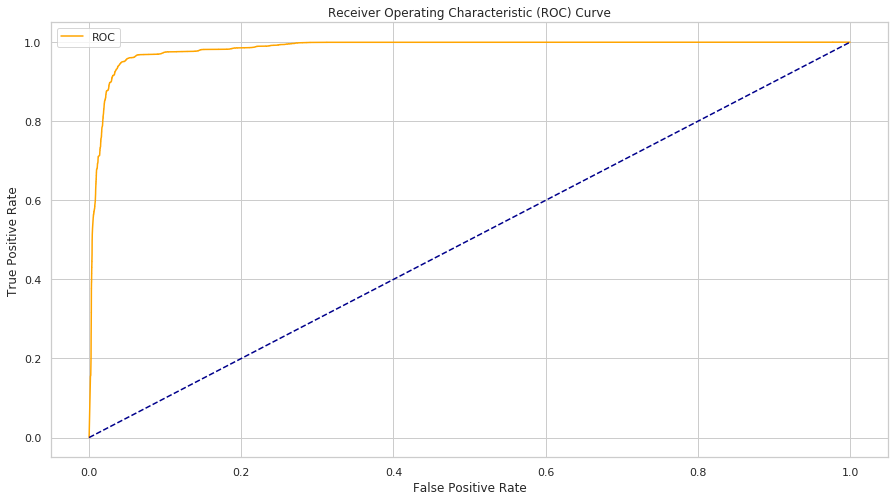

In [20]:
logisticRegression_model = LogisticRegression(solver='saga',max_iter=500,warm_start=True,n_jobs=-1,verbose=2)
logisticRegression = logisticRegression_model.fit(X_train_logreg, y_train)
joblib.dump(logisticRegression, 'logisticRegression.sav')

predict(logisticRegression, X_valid_logreg, y_valid)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 242 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.0min finished


Accuracy: 96.57%

Classification Report
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    677769
           1       0.48      1.00      0.65     22215

    accuracy                           0.97    699984
   macro avg       0.74      0.98      0.82    699984
weighted avg       0.98      0.97      0.97    699984



Confusion-matrix
 Predicted Species       0      1
Actual Species                  
0                  653733  24036
1                       5  22210


ROC-AUC: 0.9972540582711685



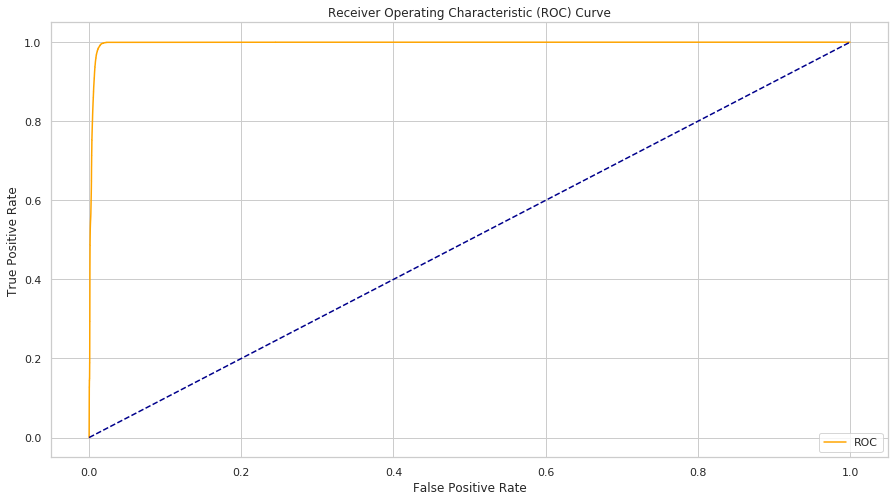

In [21]:
logisticRegression_model = LogisticRegression(solver='saga',max_iter=500,warm_start=True,n_jobs=-1,verbose=2)
logisticRegression = logisticRegression_model.fit(X_train, y_train)
joblib.dump(logisticRegression, 'logisticRegression.sav')

predict(logisticRegression, X_valid, y_valid)

In [31]:
linearSVC_model = LinearSVC(verbose=2)

feature_map_nystroem = Nystroem(random_state=0,n_components=50)
X_train_transformed = feature_map_nystroem.fit_transform(X_train)
X_valid_transformed = feature_map_nystroem.fit_transform(X_valid)

linearSVC = linearSVC_model.fit(X_train, y_train)
linearSVC_prediction = linearSVC.predict(X_valid)

accuracy = accuracy_score(y_valid, linearSVC_prediction)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print("\nClassification Report\n {}\n".format(classification_report(y_valid, linearSVC_prediction)))

print("\nConfusion-matrix\n {}\n".format(pd.crosstab(y_valid, linearSVC_prediction, rownames=['Actual Species'], colnames=['Predicted Species'])))

[LibLinear]Accuracy: 96.68%

Classification Report
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    677769
           1       0.49      1.00      0.66     22215

    accuracy                           0.97    699984
   macro avg       0.74      0.98      0.82    699984
weighted avg       0.98      0.97      0.97    699984



Confusion-matrix
 Predicted Species       0      1
Actual Species                  
0                  654539  23230
1                       0  22215



In [0]:
grid = {'alpha': [1e-2, 1e-1, 1e0, 1e1, 1e2],
        'max_iter': [500],
        'loss': ['log', 'modified_huber', 'squared_hinge', 'perceptron'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'eta0': [0.2],
        'fit_intercept': [True,False],
        'shuffle': [True,False],
        'early_stopping': [True,False],
        'penalty': ['l2','elasticnet'],
        'n_jobs': [-1]}

paramGrid = ParameterGrid(grid)
SGDClassifier_model = linear_model.SGDClassifier()
bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier_model, paramGrid,
                                                        X_train, y_train, X_valid, y_valid, 
                                                        metric = roc_auc_score, scoreLabel = 'AUC')

print(bestModel, bestScore)

SGDClassifier(alpha=0.01, average=False, class_weight=None, early_stopping=True,
              epsilon=0.1, eta0=0.2, fit_intercept=True, l1_ratio=0.15,
              learning_rate='invscaling', loss='log', max_iter=500,
              n_iter_no_change=5, n_jobs=-1, penalty='elasticnet', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) 0.9980472270206788


Accuracy: 97.86%

Classification Report
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    677769
           1       0.60      1.00      0.75     22215

    accuracy                           0.98    699984
   macro avg       0.80      0.99      0.87    699984
weighted avg       0.99      0.98      0.98    699984



Confusion-matrix
 Predicted Species       0      1
Actual Species                  
0                  662785  14984
1                       1  22214


ROC-AUC: 0.9980109861953459



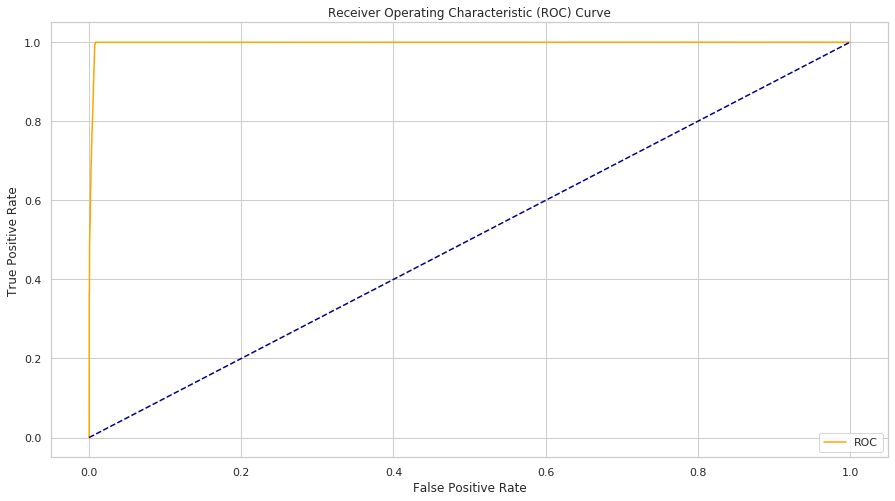

In [46]:
SGDClassifier_model = linear_model.SGDClassifier(alpha=0.01, average=False, class_weight=None, early_stopping=True,
              epsilon=0.1, eta0=0.2, fit_intercept=True, l1_ratio=0.15,
              learning_rate='invscaling', loss='log', max_iter=500,
              n_iter_no_change=5, n_jobs=-1, penalty='elasticnet', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

SGDClassifier = SGDClassifier_model.fit(X_train, y_train)
predict(SGDClassifier,X_valid,y_valid)

In [0]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [5, 10, 15, 20]
min_samples_leaf = [2, 4, 6, 8, 10]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [2, 4, 6, 8, 10],
 'min_samples_split': [5, 10, 15, 20],
 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}


In [0]:
model = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 5, cv = 10, n_jobs=-1, verbose = 2)
randomRorest_randomSearch = random_search.fit(X_train, y_train)
joblib.dump(randomRorest_randomSearch, 'randomForest_randomSearch.sav')

pprint(randomRorest_randomSearch.best_params_)

predict(randomRorest_randomSearch, X_valid, y_valid)

In [0]:
params = {'n_estimators': [130,150],
          'max_features': ['log2'],
          'max_depth': [130,150],
          'min_samples_split': [8,10],
          'min_samples_leaf': [5],
          'bootstrap': [False]}

model = RandomForestClassifier()
grid_search = GridSearchCV(estimator = model, param_grid = params, cv = 3, n_jobs=-1, verbose = 2)
randomRorest_gridSearch = grid_search.fit(X_train, y_train)
joblib.dump(randomRorest_gridSearch, 'randomForest_gridSearch.sav')

pprint(randomRorest_gridSearch.best_params_)

predict(randomRorest_gridSearch, X_valid, y_valid)

In [0]:
model = RandomForestClassifier(n_estimators=110,max_features='log2',max_depth=120,min_samples_split=8,min_samples_leaf=5,bootstrap=False,n_jobs=-1)
randomForest_basic = model.fit(X_train, y_train)
joblib.dump(randomForest_basic, 'randomForest_basic.sav')

predict(randomForest_basic, X_valid, y_valid)

In [0]:
randomForest = RandomForestClassifier(class_weight=class_weights, n_estimators=len(Counter(Y)), criterion='entropy', random_state=0, n_jobs=len(Counter(Y)), max_depth=None, bootstrap=False, n_jobs=-1)

selected_features = SelectFromModel(randomForest)
selected_features.fit(X_train, y_train)

features = X_train.columns[(selected_features.get_support())]
print("Selected features: {}".format(features))

X_train_important_features = selected_features.transform(X_train)
X_test_important_features = selected_features.transform(X_test)

In [0]:
decisionTree_model = DecisionTreeClassifier(max_features='auto')
decisionTree = decisionTree_model.fit(X_train, y_train)
joblib.dump(decisionTree, 'decisionTree.sav')

predict(decisionTree, X_valid, y_valid)